In [ ]:
    ''' Input: RGB image image.
Step 1: Convert RGB to OD
Step 2: Remove data with OD intensity less than β
Step 3: Calculate  singular value decomposition (SVD) on the OD tuples
Step 4: Create plane from the SVD directions corresponding to the
two largest singular values
Step 5: Project data onto the plane, and normalize to unit length
Step 6: Calculate angle of each point wrt the first SVD direction
Step 7: Find robust extremes (αth and (100−α)th 7 percentiles) of the
angle
Step 8: Convert extreme values back to OD space
Output: Optimal Stain Vectors
'''

' Input: RGB image image.\nStep 1: Convert RGB to OD\nStep 2: Remove data with OD intensity less than β\nStep 3: Calculate  singular value decomposition (SVD) on the OD tuples\nStep 4: Create plane from the SVD directions corresponding to the\ntwo largest singular values\nStep 5: Project data onto the plane, and normalize to unit length\nStep 6: Calculate angle of each point wrt the first SVD direction\nStep 7: Find robust extremes (αth and (100−α)th 7 percentiles) of the\nangle\nStep 8: Convert extreme values back to OD space\nOutput: Optimal Stain Vectors\n'

In [ ]:
from rasterio.plot import show, show_hist
from google.colab import files,drive
from IPython import display
import matplotlib.pyplot as plt
import cv2
import rasterio
import seaborn as sns
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow_io as tfio
import warnings
SEED = 1000
np.random.seed(SEED)
warnings.filterwarnings('ignore')
tf.random.set_seed(SEED)
tf.__version__




'2.4.1'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# !pip install rasterio
# !pip install tensorflow_io

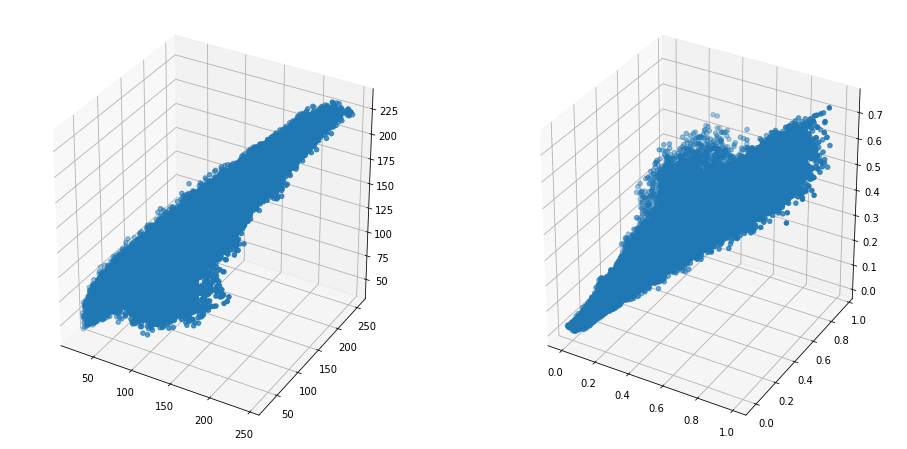

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Dataset/cll/sj-03-2810_001.jpg',-1)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
io=240
alpha=1
beta=0.15
heref=np.array([[0.5626,0.2159],[0.7201,0.8012],[0.4062,0.5581]])

maxcref=np.array([1.9705,1.0308])
h,w,c=img.shape
img=img.reshape(-1,3)
od=-np.log10((img.astype(np.float)+1)/io)

from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(16,8))
ax1=fig.add_subplot(121,projection='3d')
ax1.scatter(img[:,0],img[:,1],img[:,2])
ax2=fig.add_subplot(122,projection='3d')
ax2.scatter(od[:,0],od[:,1],od[:,2])
plt.show()

odhat=od[~np.any(od<beta,axis=1)]
eigvals,eigvecs=np.linalg.eigh(np.cov(odhat.T))
that=odhat.dot(eigvecs[:,1:3])
phi=np.arctan2(that[:,1],that[:,0])
minphi=np.percentile(phi,alpha)
maxphi=np.percentile(phi,100-alpha)
vmin=eigvecs[:,1:3].dot(np.array([(np.cos(minphi),np.sin(minphi))]).T)
vmax=eigvecs[:,1:3].dot(np.array([(np.cos(maxphi),np.sin(maxphi))]).T)

if vmin[0]>vmax[0]:
  he=np.array((vmin[:,0],vmax[:,0])).T
else:
  he=np.array((vmax[:,0],vmin[:,0])).T

y=np.reshape(od,(-1,3)).T

c=np.linalg.lstsq(he,y,rcond=None)[0]

maxc=np.array([np.percentile(c[:,0],99),np.percentile(c[1,:],99)])
tmp=np.divide(maxc,maxcref)
c2=np.divide(c,tmp[:,np.newaxis])


inorm=np.multiply(io,np.exp(-heref.dot(c2))) 

inorm[inorm>255]=254
inorm=np.reshape(inorm.T,(h,w,3)).astype(np.uint8)

H=np.multiply(io,np.exp(np.expand_dims(-heref[:,0],axis=1).dot(np.expand_dims(c2[0,:],axis=0))))

H[H>255]=254,
H=np.reshape(H.T,(h,w,3)).astype(np.uint8)



E=np.multiply(io,np.exp(np.expand_dims(-heref[:,1],axis=1).dot(np.expand_dims(c2[1,:],axis=0))))
E[E>255]=254
E=np.reshape(E.T,(h,w,3)).astype(np.uint8)


plt.imsave("/content/drive/MyDrive/normalised.jpg",inorm)
plt.imsave("/content/drive/MyDrive/separted_h.jpg",H)
plt.imsave("/content/drive/MyDrive/separated_e.jpg",E)

(1040, 1388)


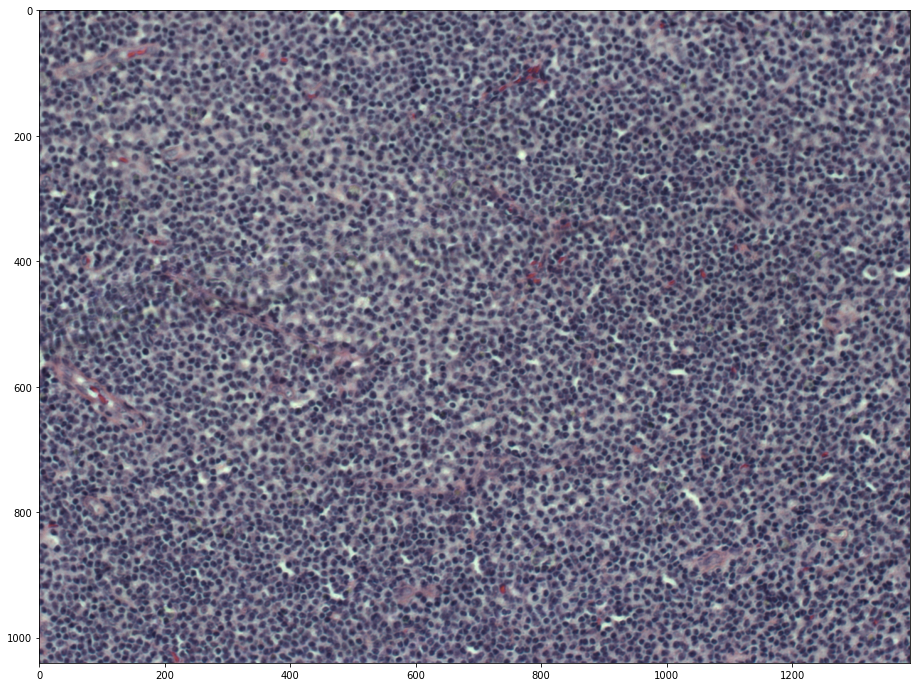

In [ ]:
fp=r"/content/drive/MyDrive/Dataset/CLL/sj-03-2810_001.tif"
src=rasterio.open(fp)
fig,ax=plt.subplots(1,figsize=(20,12))
show(src,ax=ax)
print(src.shape)


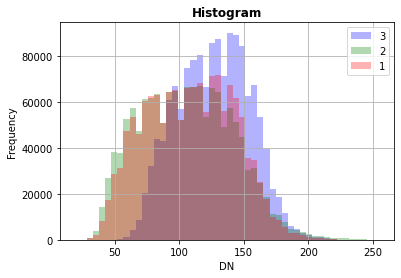

In [ ]:
show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/separted_h.jpg',0) 
  
ret, bw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) 
  
# converting to its binary form 
bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) 
  
cv2_imshow(bw_img) 
cv2.waitKey(0) 
cv2.destroyAllWindows()
img2 = cv2.imread('/content/normalised.jpg',0)
show_hist(img, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")
show_hist(img2, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

AttributeError: ignored